In [2]:
from truncated import *
from IQR import *
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%load_ext line_profiler


# Normal distribution

In [3]:
med,IQR=0,1
N=1000
T=10
Normal=Gibbs_med_IQR(T,N,med,IQR,std_prop_quantile=.01)

100%|██████████| 10/10 [00:00<00:00, 14.31it/s]

Acceptance rates of Quantile : Q 0 = 63.64%
Q 1 = 27.27%
Q 2 = 45.45%
Q 3 = 81.82%


[0.75 0.5  0.25]


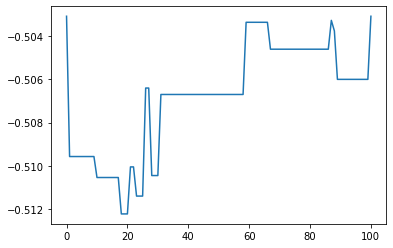

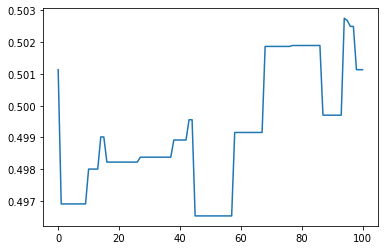

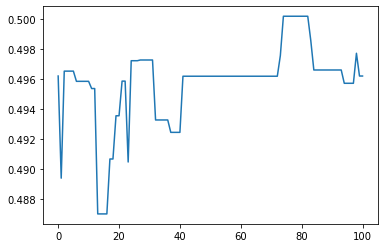

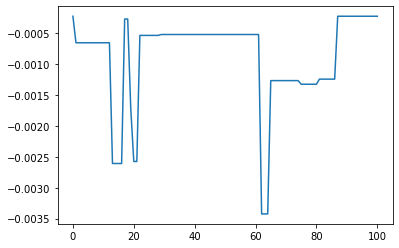

In [14]:
G=Normal["G"]
print(G)
Q=Normal["Q_sim"]
for i in range(Q.shape[1]):
    plt.plot(Normal["Q_sim"].T[-i])
    plt.show()

0.023608217032314877 0.7470674672258935


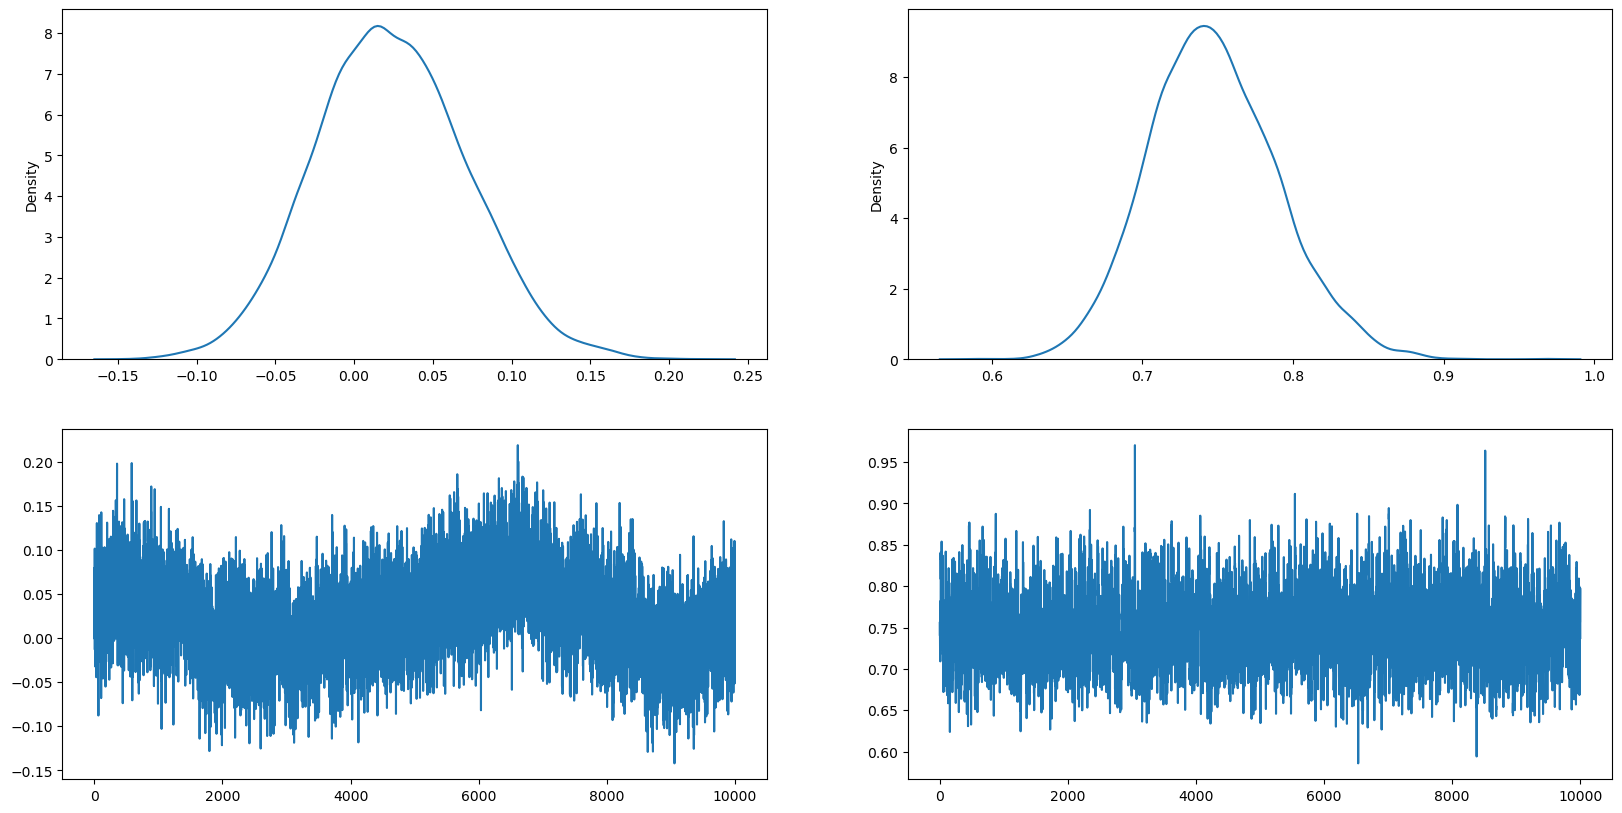

In [62]:
Gibbs=Normal
f,ax=plt.subplots(2,2,figsize=(20,10))
sns.kdeplot(Gibbs["chains"][0],ax=ax[0,0])
ax[1,0].plot(Gibbs["chains"][0])

sns.kdeplot(Gibbs["chains"][1],ax=ax[0,1])
ax[1,1].plot(Gibbs["chains"][1])

print(np.mean(Gibbs["chains"][0]),np.mean(Gibbs["chains"][1]))

# Test IQR


In [130]:
m,iqr = -5,8
N= 1000
T=100000

IQR0 = Gibbs_med_IQR(T,N,m,iqr,1,"normal",std_prop_quantile=.02,par_prior=[0,5,1,1])

[-5, 5.930408874022408] [-5.  8.] [-9.12415674, -9.12017213, -5.01324174, -4.98675826, -1.12129482, -1.12078868] [-9.12415674, -5.01324174, -1.12129482, -1.12078868] [-9.12116828 -5.         -1.12116828]


100%|██████████| 100000/100000 [16:57<00:00, 98.28it/s]


(4, 100001)
Acceptance rate of Q 0 = 41.61%
Acceptance rate of Q 1 = 45.74%
Acceptance rate of Q 2 = 41.26%
Acceptance rate of Q 3 = 42.11%
Acceptance rate of Q =  87.58%


In [134]:
Q1,M,Q3=[],[],[]
med=-5
for i in tqdm(range(100000)):
    Y=np.random.normal(-5,0.7413*iqr,1000)
    m_Y, s_Y = np.median(Y), scipy.stats.iqr(Y)
    X_0= np.sort(np.round((Y - m_Y) / s_Y * iqr+ med, 8))
    
    Q1.append(np.quantile(X_0,.25))
    M.append(np.median(X_0))
    Q3.append(np.quantile(X_0,.75))
    

100%|██████████| 100000/100000 [00:28<00:00, 3528.68it/s]


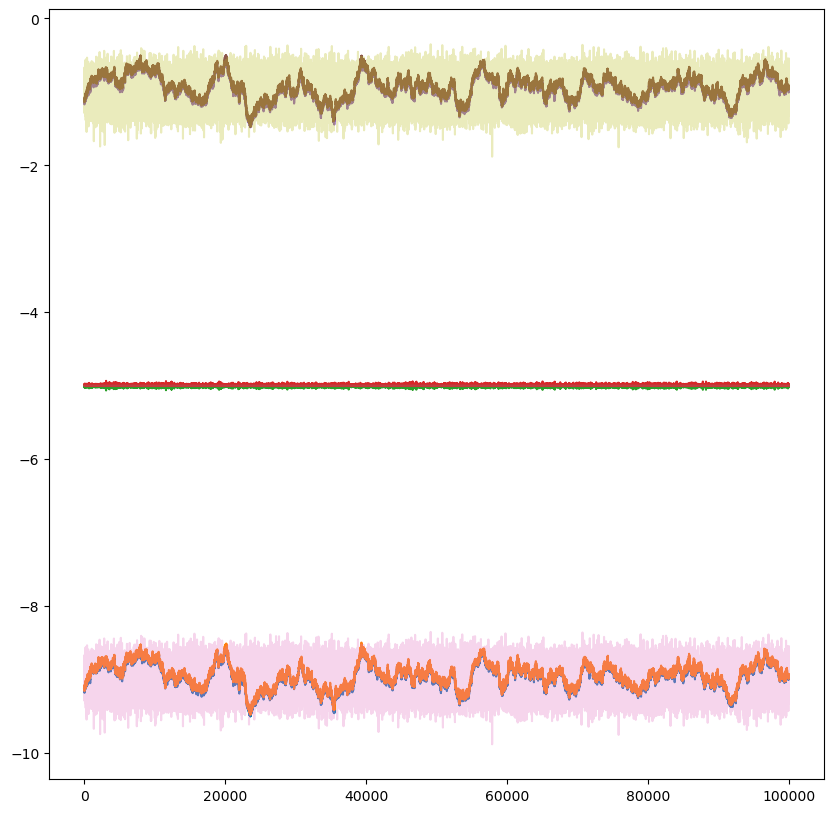

In [135]:

plt.figure(figsize=(10,10))
Q_S= np.array(IQR0["Q_tot"])

plt.plot(Q_S)

plt.plot(Q1,alpha=.3)
plt.plot(M,alpha=.3)
plt.plot(Q3,alpha=.3)

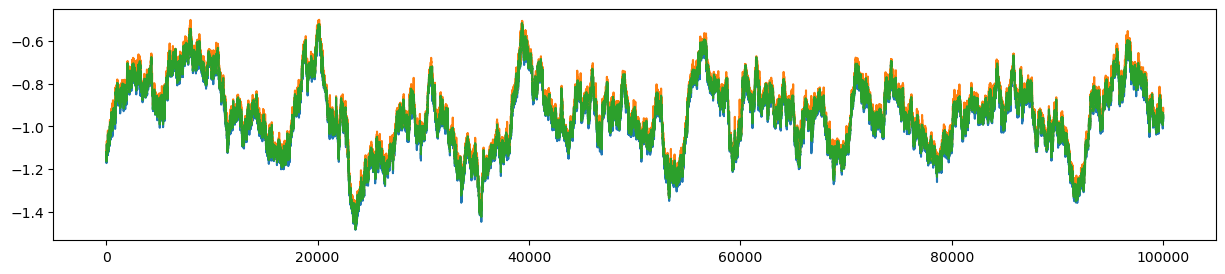

In [136]:
plt.figure(figsize=(15,3))
plt.plot(Q_S.T[4].T)
plt.plot(Q_S.T[5].T)
plt.plot(Q_S.T[5].T*0.25+Q_S.T[4].T*0.75)


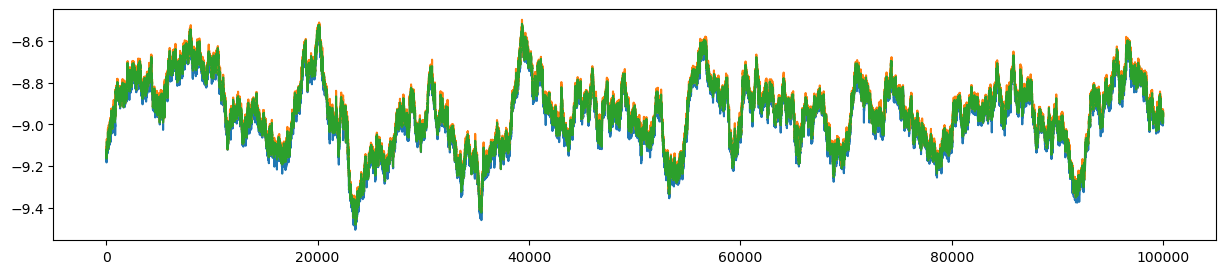

In [137]:
plt.figure(figsize=(15,3))
plt.plot(Q_S.T[0].T)
plt.plot(Q_S.T[1].T)
plt.plot(Q_S.T[0].T*0.25+Q_S.T[1].T*0.75)

In [138]:
np.unique(Q_S.T[5].T*0.25+Q_S.T[4].T*0.75-(Q_S.T[0].T*0.25+Q_S.T[1].T*0.75))

array([8., 8., 8., 8., 8.])

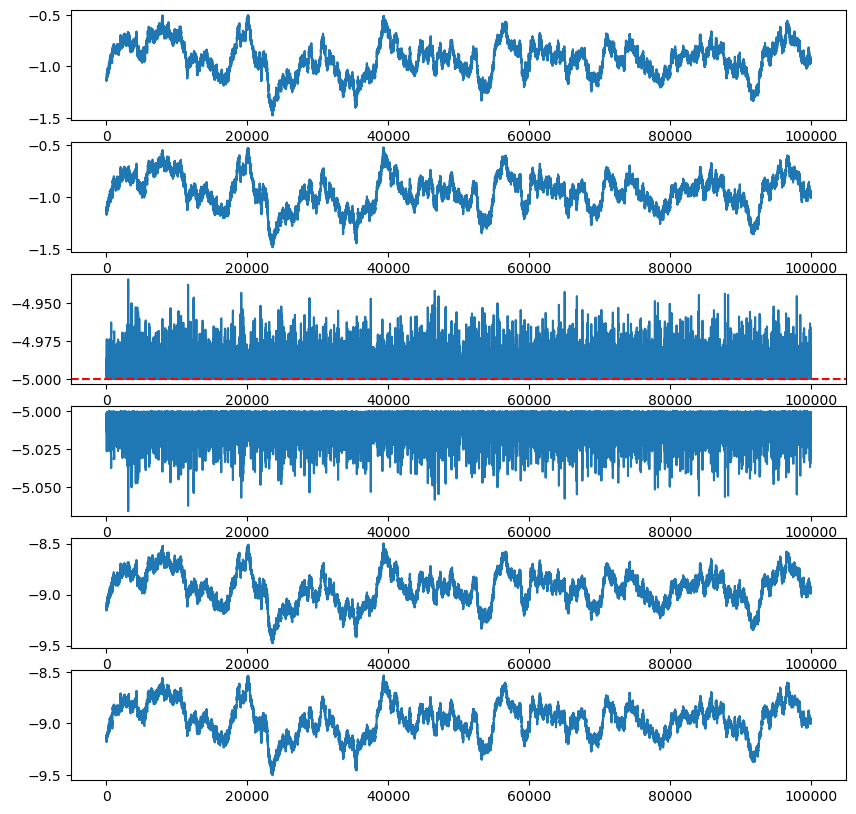

In [139]:
Q_ALL=np.array(IQR0["Q_tot"])


f,ax=plt.subplots(Q_ALL.shape[1],figsize=(10,10))
for i,q in enumerate(Q_ALL.T[::-1]):
    ax[i].plot(q)
ax[2].axhline(m,linestyle="--",color="red")

0.3675229375956029

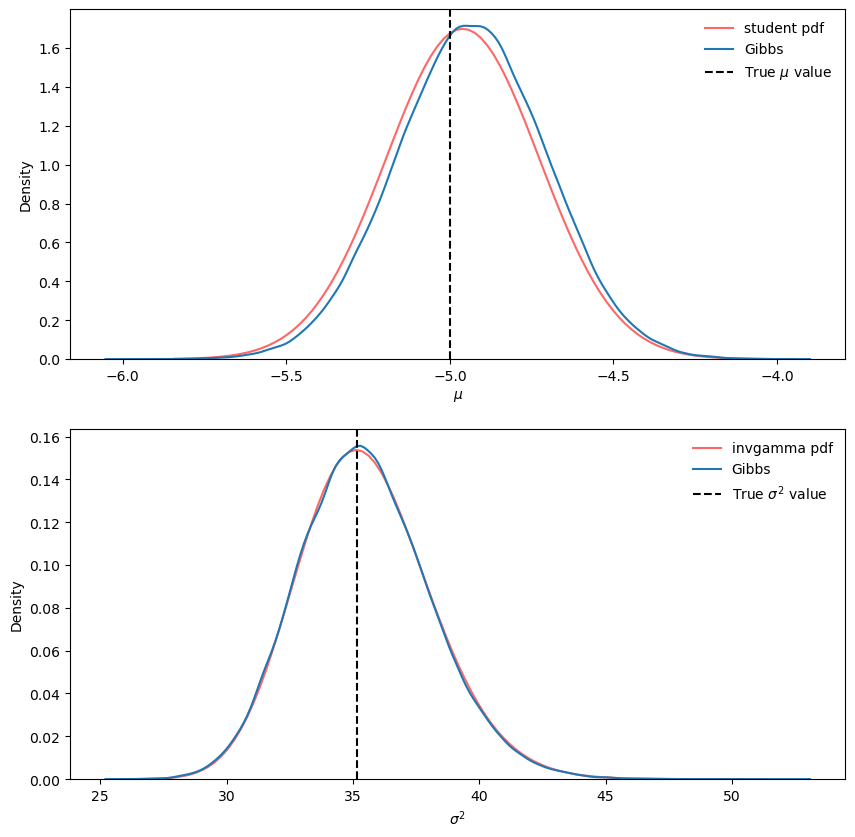

In [141]:
import numpy as np
from scipy.stats import t,invgamma
import matplotlib.pyplot as plt
from scipy.special import gamma
dico= IQR0
fig, ax = plt.subplots(2,figsize=(10,10))

mu_0,nu,alpha,beta = dico["par_prior"]
mu_chain,sigma2_chain = dico["chains"][0],dico["chains"][1]**2
N=dico["N"]
N_mean,N_var=int(N * 2/np.math.pi),int(N*scipy.stats.norm.ppf(.25)**2/(np.math.pi/4*np.exp(scipy.stats.norm.ppf(.25)**2)))
S2= (dico["IQR"]/(2*scipy.stats.norm.ppf(0.75)))**2
med=dico["med"]

alpha_n = alpha + N_var / 2
beta_n = beta+ (N_var * S2+ N_mean * nu * (med - mu_0) ** 2 / (nu + N_mean))/ 2
mu_n = (nu * mu_0 + N_mean * med) / (nu + N_mean)
nu_n = nu + N_mean

loc=mu_n
scale=np.sqrt(beta_n/(alpha_n*nu_n))
df=2*alpha_n


x = np.linspace(t.ppf(0.0001, df, loc=loc, scale=scale),
                t.ppf(0.99999, df, loc=loc,scale=scale), 100)


ax[0].plot(x, t.pdf(x, df, loc=loc, scale=scale), 'r-', alpha=0.6, label='student pdf')
sns.kdeplot(mu_chain,ax=ax[0],label="Gibbs")
ax[0].axvline(x=med,linestyle="--",color="black",label="True $\mu$ value")
ax[0].legend(loc='best', frameon=False)
ax[0].set_xlabel("$\mu$")

x = np.linspace(invgamma.ppf(0.00001, alpha_n, scale=beta_n),
                invgamma.ppf(0.999999, alpha_n, scale=beta_n), 100)

ax[1].plot(x,invgamma.pdf(x, alpha_n, scale=beta_n),'r-', alpha=0.6, label='invgamma pdf')
sns.kdeplot(sigma2_chain,ax=ax[1],label="Gibbs")
ax[1].axvline(x=S2,linestyle="--",color="black",label="True $\sigma^2$ value")
ax[1].legend(loc='best', frameon=False)
ax[1].set_xlabel("$\sigma^2$")

par=[mu_n,nu_n,alpha_n,beta_n]

In [145]:
m,iqr = -5,8
N= 1000
T=100000

IQR1= Gibbs_med_IQR(T,N+1,m,iqr,1,"normal",std_prop_quantile=1.7,par_prior=[0,5,1,1])

[-5, 5.930408874022408] [-5.  8.] [-9.00301435, -5.0, -1.00301435] [-9.00301435] [-9.00301435 -5.         -1.00301435]


100%|██████████| 100000/100000 [07:54<00:00, 210.92it/s]


(1, 100001)
Acceptance rate of Q 0 = 37.93%
Acceptance rate of Q =  37.93%


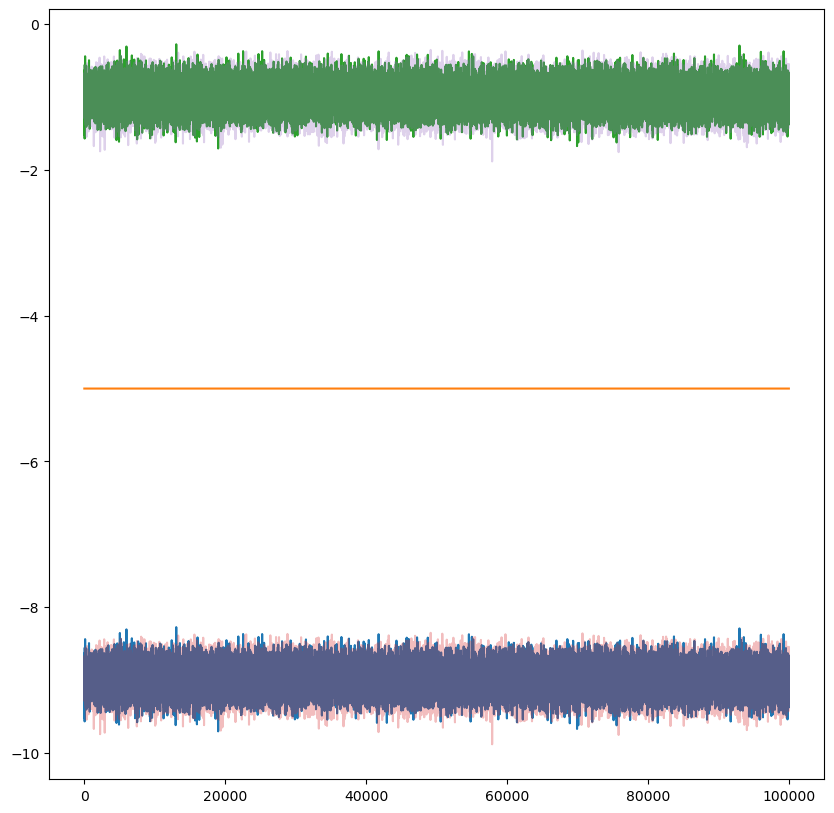

In [152]:
Q_S= np.array(IQR1["Q_tot"])
plt.figure(figsize=(10,10))
plt.plot(Q_S)
plt.plot(Q1[:Q_S.shape[0]],alpha=.3)
plt.plot(Q3[:Q_S.shape[0]],alpha=.3)

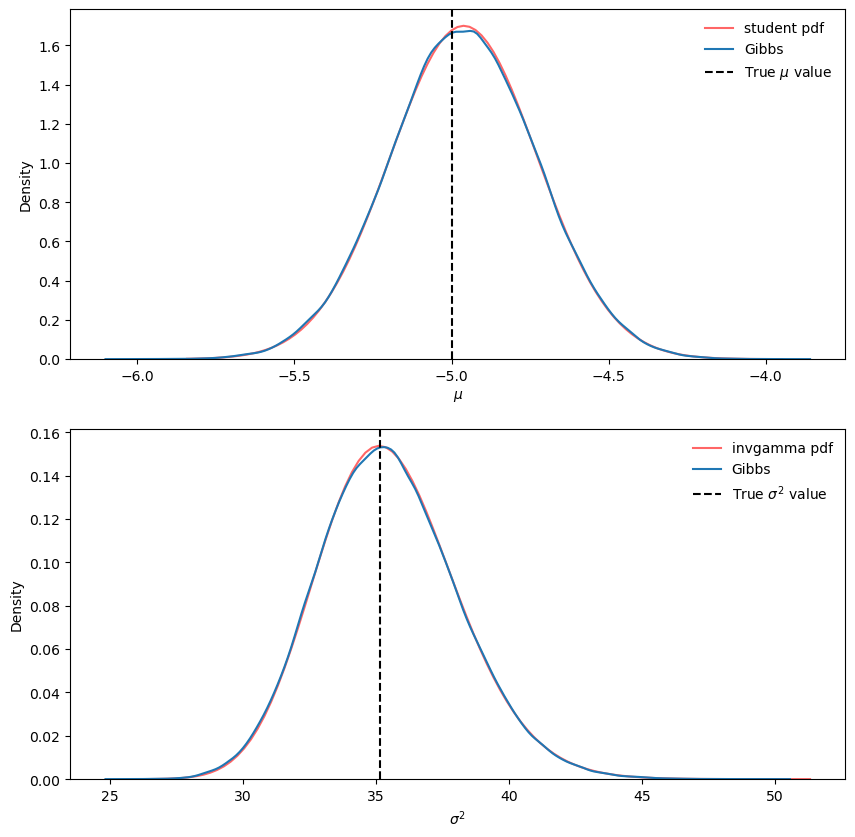

In [154]:
import numpy as np
from scipy.stats import t,invgamma
import matplotlib.pyplot as plt
from scipy.special import gamma
dico= IQR1
fig, ax = plt.subplots(2,figsize=(10,10))

mu_0,nu,alpha,beta = dico["par_prior"]
mu_chain,sigma2_chain = dico["chains"][0],dico["chains"][1]**2
N=dico["N"]
N_mean,N_var=int(N * 2/np.math.pi),int(N*scipy.stats.norm.ppf(.25)**2/(np.math.pi/4*np.exp(scipy.stats.norm.ppf(.25)**2)))
S2= (dico["IQR"]/(2*scipy.stats.norm.ppf(0.75)))**2
med=dico["med"]

alpha_n = alpha + N_var / 2
beta_n = beta+ (N_var * S2+ N_mean * nu * (med - mu_0) ** 2 / (nu + N_mean))/ 2
mu_n = (nu * mu_0 + N_mean * med) / (nu + N_mean)
nu_n = nu + N_mean

loc=mu_n
scale=np.sqrt(beta_n/(alpha_n*nu_n))
df=2*alpha_n


x = np.linspace(t.ppf(0.0001, df, loc=loc, scale=scale),
                t.ppf(0.99999, df, loc=loc,scale=scale), 100)


ax[0].plot(x, t.pdf(x, df, loc=loc, scale=scale), 'r-', alpha=0.6, label='student pdf')
sns.kdeplot(mu_chain,ax=ax[0],label="Gibbs")
ax[0].axvline(x=med,linestyle="--",color="black",label="True $\mu$ value")
ax[0].legend(loc='best', frameon=False)
ax[0].set_xlabel("$\mu$")

x = np.linspace(invgamma.ppf(0.00001, alpha_n, scale=beta_n),
                invgamma.ppf(0.999999, alpha_n, scale=beta_n), 100)

ax[1].plot(x,invgamma.pdf(x, alpha_n, scale=beta_n),'r-', alpha=0.6, label='invgamma pdf')
sns.kdeplot(sigma2_chain,ax=ax[1],label="Gibbs")
ax[1].axvline(x=S2,linestyle="--",color="black",label="True $\sigma^2$ value")
ax[1].legend(loc='best', frameon=False)
ax[1].set_xlabel("$\sigma^2$")

par=[mu_n,nu_n,alpha_n,beta_n]

In [157]:
m,iqr = -5,8
N= 1000
T=100000

IQR2= Gibbs_med_IQR(T,N+2,m,iqr,1,"normal",std_prop_quantile=.02,par_prior=[0,5,1,1])

[-5, 5.930408874022408] [-5.  8.] [-8.89524792, -8.88632316, -5.00029505, -4.99970495, -0.89650791, -0.891853] [-8.89524792, -5.00029505, -0.89650791, -0.891853] [-8.89301673 -5.         -0.89301673]


100%|██████████| 100000/100000 [17:00<00:00, 97.97it/s]


(4, 100001)
Acceptance rate of Q 0 = 41.61%
Acceptance rate of Q 1 = 45.84%
Acceptance rate of Q 2 = 40.62%
Acceptance rate of Q 3 = 41.41%
Acceptance rate of Q =  87.06%


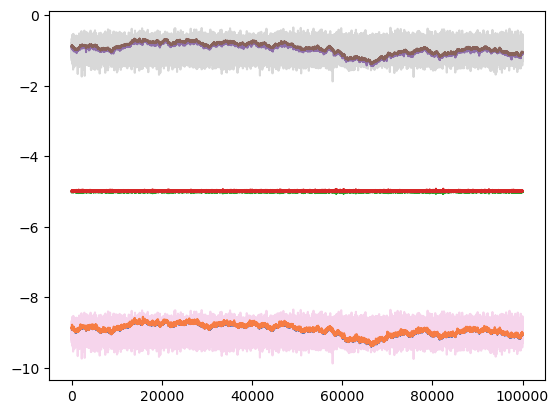

In [160]:
Q_S= np.array(IQR2["Q_tot"])


plt.plot(Q_S)
plt.plot(Q1[:Q_S.shape[0]],alpha=.3)
plt.plot(Q3[:Q_S.shape[0]],alpha=.3)

In [ ]:
Q1,Q3=[],[]
for i in tqdm(range(20000)):
    X=np.random.normal(-5,0.7413*iqr,402)
    Q1.append(np.quantile(X,.25))
    Q3.append(np.quantile(X,.75))

100%|██████████| 20000/20000 [00:02<00:00, 7053.69it/s]


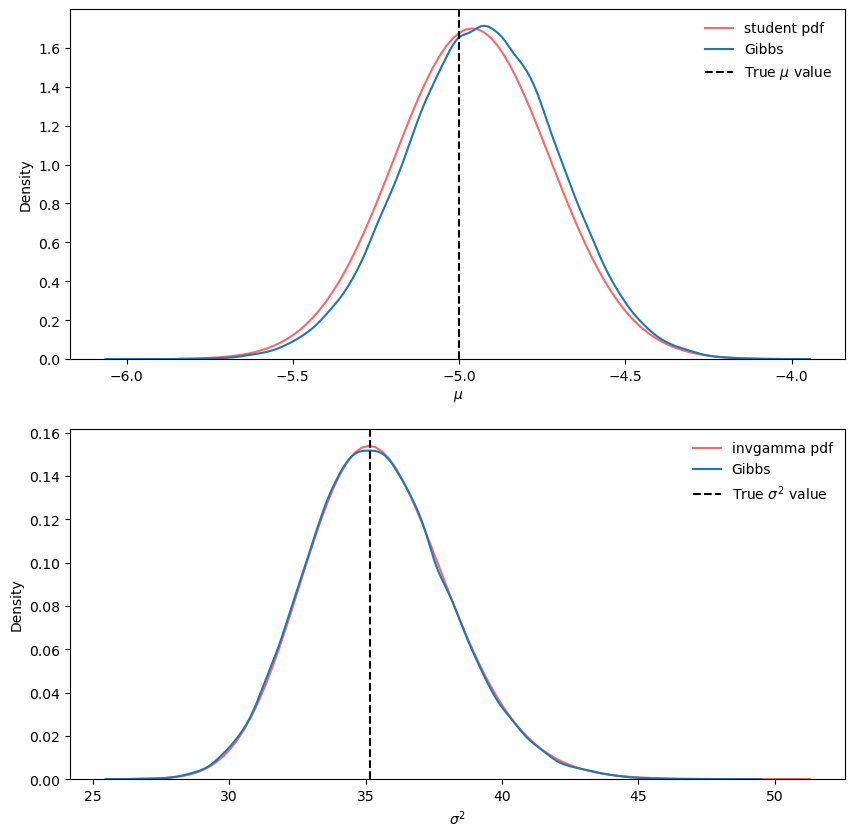

In [161]:
import numpy as np
from scipy.stats import t,invgamma
import matplotlib.pyplot as plt
from scipy.special import gamma
dico= IQR2
fig, ax = plt.subplots(2,figsize=(10,10))

mu_0,nu,alpha,beta = dico["par_prior"]
mu_chain,sigma2_chain = dico["chains"][0],dico["chains"][1]**2
N=dico["N"]
N_mean,N_var=int(N * 2/np.math.pi),int(N*scipy.stats.norm.ppf(.25)**2/(np.math.pi/4*np.exp(scipy.stats.norm.ppf(.25)**2)))
S2= (dico["IQR"]/(2*scipy.stats.norm.ppf(0.75)))**2
med=dico["med"]

alpha_n = alpha + N_var / 2
beta_n = beta+ (N_var * S2+ N_mean * nu * (med - mu_0) ** 2 / (nu + N_mean))/ 2
mu_n = (nu * mu_0 + N_mean * med) / (nu + N_mean)
nu_n = nu + N_mean

loc=mu_n
scale=np.sqrt(beta_n/(alpha_n*nu_n))
df=2*alpha_n


x = np.linspace(t.ppf(0.0001, df, loc=loc, scale=scale),
                t.ppf(0.99999, df, loc=loc,scale=scale), 100)


ax[0].plot(x, t.pdf(x, df, loc=loc, scale=scale), 'r-', alpha=0.6, label='student pdf')
sns.kdeplot(mu_chain,ax=ax[0],label="Gibbs")
ax[0].axvline(x=med,linestyle="--",color="black",label="True $\mu$ value")
ax[0].legend(loc='best', frameon=False)
ax[0].set_xlabel("$\mu$")

x = np.linspace(invgamma.ppf(0.00001, alpha_n, scale=beta_n),
                invgamma.ppf(0.999999, alpha_n, scale=beta_n), 100)

ax[1].plot(x,invgamma.pdf(x, alpha_n, scale=beta_n),'r-', alpha=0.6, label='invgamma pdf')
sns.kdeplot(sigma2_chain,ax=ax[1],label="Gibbs")
ax[1].axvline(x=S2,linestyle="--",color="black",label="True $\sigma^2$ value")
ax[1].legend(loc='best', frameon=False)
ax[1].set_xlabel("$\sigma^2$")

par=[mu_n,nu_n,alpha_n,beta_n]

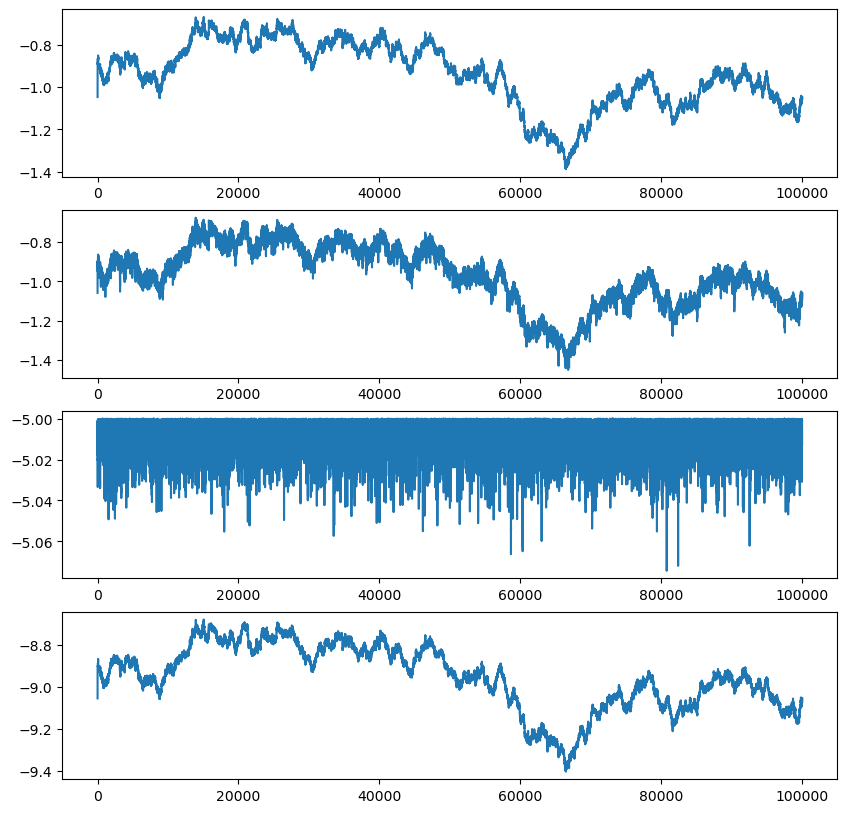

In [164]:
Q_ALL=np.array(IQR2["Q_sim"])


f,ax=plt.subplots(Q_ALL.shape[1],figsize=(10,10))
for i,q in enumerate(Q_ALL.T[::-1]):
    ax[i].plot(q)
#ax[2].axhline(0,linestyle="--",color="red")

In [210]:
m,iqr = -5,8
N= 1000
T=200000

IQR3= Gibbs_med_IQR(T,N+3,m,iqr,1,"normal",std_prop_quantile=.03,par_prior=[0,5,1,1])

[-5, 5.930408874022408] [-5.  8.] [-8.92381695, -8.92303641, -5.0, -0.92782188, -0.91903148] [-8.92381695, -0.92782188, -0.91903148] [-8.92342668 -5.         -0.92342668]


100%|██████████| 200000/200000 [25:23<00:00, 131.29it/s]


(3, 200001)
Acceptance rate of Q 0 = 38.81%
Acceptance rate of Q 1 = 37.61%
Acceptance rate of Q 2 = 38.83%
Acceptance rate of Q =  73.41%


In [ ]:
test = [np.std(X)/iqr for X in IQR3["X"][0]]
np.mean(test),np.std(test)

(0.7391560453804087, 0.03211373610554433)

In [211]:
Q1,Q3=[],[]
for i in tqdm(range(200000)):
    X=np.random.normal(-5,0.74*iqr,N+3)
    Q1.append(np.quantile(X,.25))
    Q3.append(np.quantile(X,.75))

100%|██████████| 200000/200000 [00:24<00:00, 8104.89it/s]


In [ ]:
Q_S.sh

5

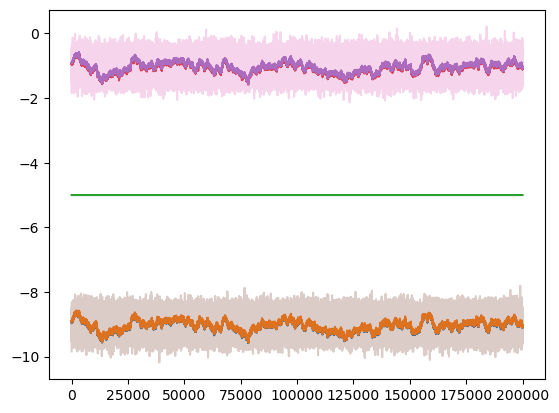

In [212]:
Q_S= np.array(IQR3["Q_tot"])

plt.plot(Q_S)
plt.plot(Q1[:Q_S.shape[0]],alpha=.3)
plt.plot(Q3[:Q_S.shape[0]],alpha=.3)

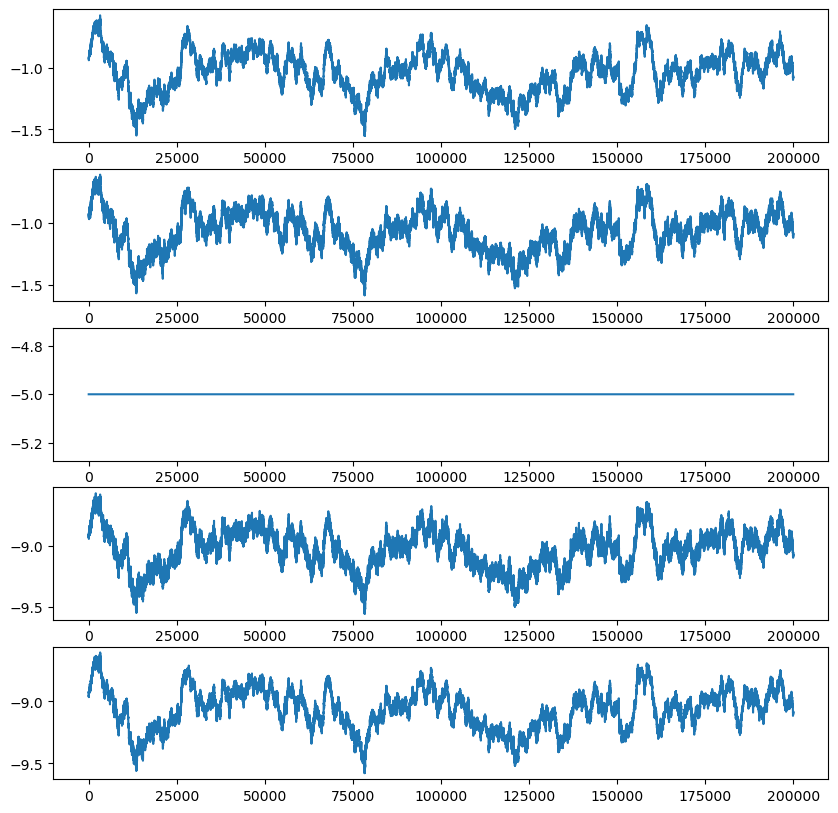

In [213]:
Q_ALL=np.array(IQR3["Q_tot"])


f,ax=plt.subplots(Q_ALL.shape[1],figsize=(10,10))
for i,q in enumerate(Q_ALL.T[::-1]):
    ax[i].plot(q)

#ax[2].axhline(m,linestyle="--",color="red")

In [203]:
np.mean(Q_ALL.T[-2:],axis=0)-np.mean(Q_ALL.T[:2],axis=0)

array([8., 8., 8., ..., 8., 8., 8.])

In [204]:
for i in np.unique(np.mean(Q_ALL.T[-2:],axis=0)-np.mean(Q_ALL.T[:2],axis=0)):
    print(i)

7.999999999999998
7.999999999999999
8.0
8.000000000000002


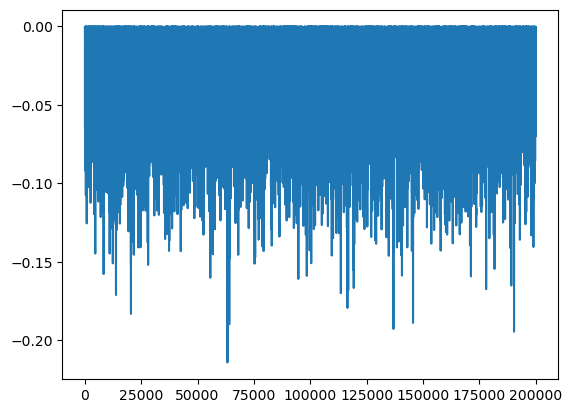

In [214]:
plt.plot(Q_ALL.T[0]-Q_ALL.T[1])

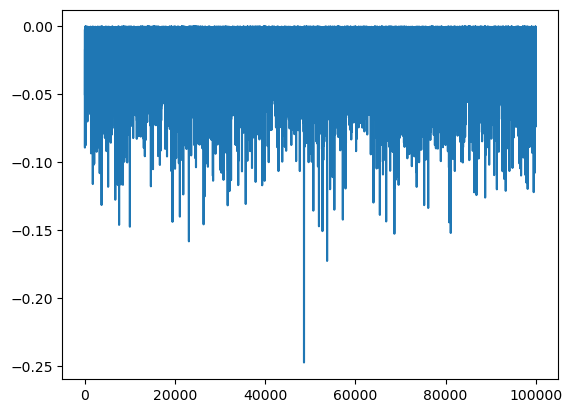

In [206]:
plt.plot(Q_ALL.T[-2]-Q_ALL.T[-1])

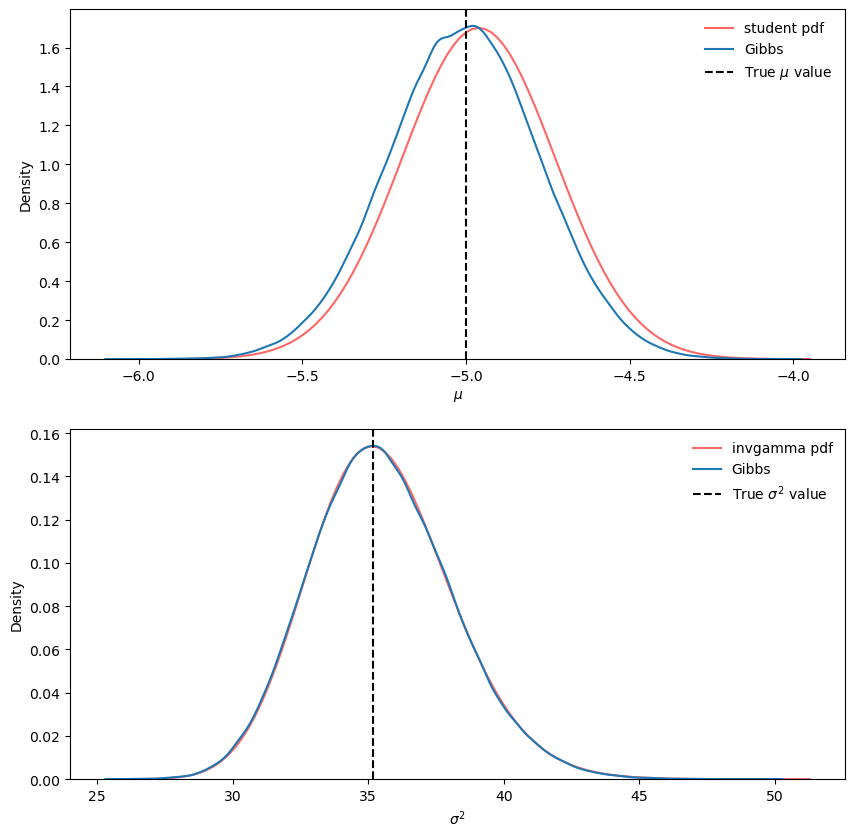

In [215]:
import numpy as np
from scipy.stats import t,invgamma
import matplotlib.pyplot as plt
from scipy.special import gamma
dico= IQR3
fig, ax = plt.subplots(2,figsize=(10,10))

mu_0,nu,alpha,beta = dico["par_prior"]
mu_chain,sigma2_chain = dico["chains"][0],dico["chains"][1]**2
N=dico["N"]
N_mean,N_var=int(N * 2/np.math.pi),int(N*scipy.stats.norm.ppf(.25)**2/(np.math.pi/4*np.exp(scipy.stats.norm.ppf(.25)**2)))
S2= (dico["IQR"]/(2*scipy.stats.norm.ppf(0.75)))**2
med=dico["med"]

alpha_n = alpha + N_var / 2
beta_n = beta+ (N_var * S2+ N_mean * nu * (med - mu_0) ** 2 / (nu + N_mean))/ 2
mu_n = (nu * mu_0 + N_mean * med) / (nu + N_mean)
nu_n = nu + N_mean

loc=mu_n
scale=np.sqrt(beta_n/(alpha_n*nu_n))
df=2*alpha_n


x = np.linspace(t.ppf(0.0001, df, loc=loc, scale=scale),
                t.ppf(0.99999, df, loc=loc,scale=scale), 100)


ax[0].plot(x, t.pdf(x, df, loc=loc, scale=scale), 'r-', alpha=0.6, label='student pdf')
sns.kdeplot(mu_chain,ax=ax[0],label="Gibbs")
ax[0].axvline(x=med,linestyle="--",color="black",label="True $\mu$ value")
ax[0].legend(loc='best', frameon=False)
ax[0].set_xlabel("$\mu$")

x = np.linspace(invgamma.ppf(0.00001, alpha_n, scale=beta_n),
                invgamma.ppf(0.999999, alpha_n, scale=beta_n), 100)

ax[1].plot(x,invgamma.pdf(x, alpha_n, scale=beta_n),'r-', alpha=0.6, label='invgamma pdf')
sns.kdeplot(sigma2_chain,ax=ax[1],label="Gibbs")
ax[1].axvline(x=S2,linestyle="--",color="black",label="True $\sigma^2$ value")
ax[1].legend(loc='best', frameon=False)
ax[1].set_xlabel("$\sigma^2$")

par=[mu_n,nu_n,alpha_n,beta_n]

# Cauchy

In [7]:
T=10000
N=1001
med,MAD=0,1
std=.1
std2=1.5

Cauchy_med_IQR=[]
Cauchy_X=[]
n_chains=15
for i in range(n_chains):
    X=np.round(scipy.stats.cauchy.rvs(loc=med,scale=MAD,size=N),8)
    med_X,MAD_X=np.round([np.median(X),scipy.stats.iqr(X)],8)
    Cauchy_med_IQR.append(Gibbs_med_IQR(T,N,med_X,MAD_X,1,"cauchy",std_prop1=std,std_prop2=std,std_prop_quantile=std2))
    Cauchy_X.append(Gibbs_med_IQR(T,N,med_X,MAD_X,1,"cauchy",std_prop1=std,std_prop2=std,perturb=False,std_prop_quantile=std2,init_X=X))



[0.07414464, 2.050815185] [0.07414464 4.10163037] [-1.95309285, 0.07414464, 2.14853752] [-1.95309285] [-1.95309285  0.07414464  2.14853752]


100%|██████████| 10000/10000 [00:47<00:00, 208.88it/s]


(1, 10001)
Acceptance rate of Q 0 = 41.72%
Acceptance rate of Q =  41.71%
Acceptation rate of loc = 68.26% and of scale = 67.98%
[0.07414464, 2.050815185] [0.07414464 4.10163037] [-1.89425452, 0.07414464, 2.20737585] [-1.89425452] [-1.89425452  0.07414464  2.20737585]


100%|██████████| 10000/10000 [00:01<00:00, 8312.05it/s]


(1, 10001)
Acceptance rate of Q 0 = 0.01%
Acceptance rate of Q =  0.00%
Acceptation rate of loc = 68.73% and of scale = 68.29%
[-0.0063836, 1.95497224] [-0.0063836   3.90994448] [-1.70842262, -0.0063836, 2.20152186] [-1.70842262] [-1.70842262 -0.0063836   2.20152186]


100%|██████████| 10000/10000 [00:48<00:00, 204.25it/s]


(1, 10001)
Acceptance rate of Q 0 = 41.89%
Acceptance rate of Q =  41.88%
Acceptation rate of loc = 67.13% and of scale = 67.00%
[-0.0063836, 1.95497224] [-0.0063836   3.90994448] [-1.90726496, -0.0063836, 2.00267952] [-1.90726496] [-1.90726496 -0.0063836   2.00267952]


100%|██████████| 10000/10000 [00:01<00:00, 8297.66it/s]


(1, 10001)
Acceptance rate of Q 0 = 0.01%
Acceptance rate of Q =  0.00%
Acceptation rate of loc = 67.48% and of scale = 69.74%
[0.0897651, 1.927984095] [0.0897651  3.85596819] [-1.57175036, 0.0897651, 2.28421783] [-1.57175036] [-1.57175036  0.0897651   2.28421783]


100%|██████████| 10000/10000 [00:47<00:00, 208.81it/s]


(1, 10001)
Acceptance rate of Q 0 = 42.11%
Acceptance rate of Q =  42.10%
Acceptation rate of loc = 67.12% and of scale = 67.05%
[0.0897651, 1.927984095] [0.0897651  3.85596819] [-1.69078731, 0.0897651, 2.16518088] [-1.69078731] [-1.69078731  0.0897651   2.16518088]


100%|██████████| 10000/10000 [00:01<00:00, 8719.00it/s]


(1, 10001)
Acceptance rate of Q 0 = 0.01%
Acceptance rate of Q =  0.00%
Acceptation rate of loc = 67.37% and of scale = 67.65%
[-0.09461792, 1.991374675] [-0.09461792  3.98274935] [-2.28880718, -0.09461792, 1.69394217] [-2.28880718] [-2.28880718 -0.09461792  1.69394217]


100%|██████████| 10000/10000 [00:47<00:00, 209.51it/s]


(1, 10001)
Acceptance rate of Q 0 = 42.01%
Acceptance rate of Q =  42.00%
Acceptation rate of loc = 67.09% and of scale = 67.67%
[-0.09461792, 1.991374675] [-0.09461792  3.98274935] [-2.00038725, -0.09461792, 1.9823621] [-2.00038725] [-2.00038725 -0.09461792  1.9823621 ]


100%|██████████| 10000/10000 [00:01<00:00, 8780.50it/s]


(1, 10001)
Acceptance rate of Q 0 = 0.01%
Acceptance rate of Q =  0.00%
Acceptation rate of loc = 68.05% and of scale = 67.87%
[-0.1329551, 2.036294495] [-0.1329551   4.07258899] [-2.27766133, -0.1329551, 1.79492766] [-2.27766133] [-2.27766133 -0.1329551   1.79492766]


100%|██████████| 10000/10000 [00:47<00:00, 209.99it/s]


(1, 10001)
Acceptance rate of Q 0 = 42.60%
Acceptance rate of Q =  42.59%
Acceptation rate of loc = 68.05% and of scale = 67.68%
[-0.1329551, 2.036294495] [-0.1329551   4.07258899] [-2.25939454, -0.1329551, 1.81319445] [-2.25939454] [-2.25939454 -0.1329551   1.81319445]


100%|██████████| 10000/10000 [00:01<00:00, 8819.01it/s]


(1, 10001)
Acceptance rate of Q 0 = 0.01%
Acceptance rate of Q =  0.00%
Acceptation rate of loc = 68.32% and of scale = 68.61%
[0.04308687, 1.922323135] [0.04308687 3.84464627] [-1.94007475, 0.04308687, 1.90457152] [-1.94007475] [-1.94007475  0.04308687  1.90457152]


100%|██████████| 10000/10000 [00:48<00:00, 204.38it/s]


(1, 10001)
Acceptance rate of Q 0 = 41.07%
Acceptance rate of Q =  41.06%
Acceptation rate of loc = 65.74% and of scale = 65.81%
[0.04308687, 1.922323135] [0.04308687 3.84464627] [-1.86810975, 0.04308687, 1.97653652] [-1.86810975] [-1.86810975  0.04308687  1.97653652]


100%|██████████| 10000/10000 [00:01<00:00, 8021.24it/s]


(1, 10001)
Acceptance rate of Q 0 = 0.01%
Acceptance rate of Q =  0.00%
Acceptation rate of loc = 66.83% and of scale = 66.08%
[-0.05685142, 1.99081218] [-0.05685142  3.98162436] [-1.95494862, -0.05685142, 2.02667574] [-1.95494862] [-1.95494862 -0.05685142  2.02667574]


100%|██████████| 10000/10000 [00:48<00:00, 204.28it/s]


(1, 10001)
Acceptance rate of Q 0 = 41.70%
Acceptance rate of Q =  41.69%
Acceptation rate of loc = 67.63% and of scale = 67.44%
[-0.05685142, 1.99081218] [-0.05685142  3.98162436] [-1.93317038, -0.05685142, 2.04845398] [-1.93317038] [-1.93317038 -0.05685142  2.04845398]


100%|██████████| 10000/10000 [00:01<00:00, 8781.37it/s]


(1, 10001)
Acceptance rate of Q 0 = 0.01%
Acceptance rate of Q =  0.00%
Acceptation rate of loc = 68.03% and of scale = 66.56%
[0.00235444, 2.168214595] [2.35444000e-03 4.33642919e+00] [-2.13793862, 0.00235444, 2.19849057] [-2.13793862] [-2.13793862  0.00235444  2.19849057]


100%|██████████| 10000/10000 [00:48<00:00, 208.25it/s]


(1, 10001)
Acceptance rate of Q 0 = 41.36%
Acceptance rate of Q =  41.35%
Acceptation rate of loc = 69.62% and of scale = 69.63%
[0.00235444, 2.168214595] [2.35444000e-03 4.33642919e+00] [-2.08660064, 0.00235444, 2.24982855] [-2.08660064] [-2.08660064  0.00235444  2.24982855]


100%|██████████| 10000/10000 [00:01<00:00, 8072.44it/s]


(1, 10001)
Acceptance rate of Q 0 = 0.01%
Acceptance rate of Q =  0.00%
Acceptation rate of loc = 68.37% and of scale = 68.62%
[-0.04135356, 2.15038704] [-0.04135356  4.30077408] [-2.24044319, -0.04135356, 2.06033089] [-2.24044319] [-2.24044319 -0.04135356  2.06033089]


100%|██████████| 10000/10000 [00:50<00:00, 196.71it/s]


(1, 10001)
Acceptance rate of Q 0 = 42.56%
Acceptance rate of Q =  42.55%
Acceptation rate of loc = 67.93% and of scale = 69.29%
[-0.04135356, 2.15038704] [-0.04135356  4.30077408] [-2.22720885, -0.04135356, 2.07356523] [-2.22720885] [-2.22720885 -0.04135356  2.07356523]


100%|██████████| 10000/10000 [00:01<00:00, 8540.31it/s]


(1, 10001)
Acceptance rate of Q 0 = 0.01%
Acceptance rate of Q =  0.00%
Acceptation rate of loc = 68.80% and of scale = 67.57%
[-0.01145219, 2.036467155] [-0.01145219  4.07293431] [-2.08045811, -0.01145219, 1.9924762] [-2.08045811] [-2.08045811 -0.01145219  1.9924762 ]


100%|██████████| 10000/10000 [00:48<00:00, 207.94it/s]


(1, 10001)
Acceptance rate of Q 0 = 41.71%
Acceptance rate of Q =  41.70%
Acceptation rate of loc = 67.27% and of scale = 67.96%
[-0.01145219, 2.036467155] [-0.01145219  4.07293431] [-2.0414083, -0.01145219, 2.03152601] [-2.0414083] [-2.0414083  -0.01145219  2.03152601]


100%|██████████| 10000/10000 [00:01<00:00, 5600.63it/s]


(1, 10001)
Acceptance rate of Q 0 = 0.01%
Acceptance rate of Q =  0.00%
Acceptation rate of loc = 67.27% and of scale = 68.05%
[-0.09972387, 2.031031485] [-0.09972387  4.06206297] [-2.0401629, -0.09972387, 2.02190007] [-2.0401629] [-2.0401629  -0.09972387  2.02190007]


100%|██████████| 10000/10000 [00:48<00:00, 207.04it/s]


(1, 10001)
Acceptance rate of Q 0 = 42.16%
Acceptance rate of Q =  42.15%
Acceptation rate of loc = 67.13% and of scale = 68.00%
[-0.09972387, 2.031031485] [-0.09972387  4.06206297] [-2.11348712, -0.09972387, 1.94857585] [-2.11348712] [-2.11348712 -0.09972387  1.94857585]


100%|██████████| 10000/10000 [00:01<00:00, 8754.54it/s]


(1, 10001)
Acceptance rate of Q 0 = 0.01%
Acceptance rate of Q =  0.00%
Acceptation rate of loc = 67.76% and of scale = 67.99%
[-0.03056044, 1.973629075] [-0.03056044  3.94725815] [-1.93559699, -0.03056044, 2.01166116] [-1.93559699] [-1.93559699 -0.03056044  2.01166116]


100%|██████████| 10000/10000 [00:49<00:00, 201.65it/s]


(1, 10001)
Acceptance rate of Q 0 = 42.25%
Acceptance rate of Q =  42.24%
Acceptation rate of loc = 67.18% and of scale = 67.71%
[-0.03056044, 1.973629075] [-0.03056044  3.94725815] [-1.93240245, -0.03056044, 2.0148557] [-1.93240245] [-1.93240245 -0.03056044  2.0148557 ]


100%|██████████| 10000/10000 [00:01<00:00, 8787.52it/s]


(1, 10001)
Acceptance rate of Q 0 = 0.01%
Acceptance rate of Q =  0.00%
Acceptation rate of loc = 66.50% and of scale = 67.27%
[-0.04717825, 2.004406295] [-0.04717825  4.00881259] [-2.10838343, -0.04717825, 1.90042916] [-2.10838343] [-2.10838343 -0.04717825  1.90042916]


100%|██████████| 10000/10000 [00:48<00:00, 207.87it/s]


(1, 10001)
Acceptance rate of Q 0 = 41.43%
Acceptance rate of Q =  41.42%
Acceptation rate of loc = 67.13% and of scale = 68.15%
[-0.04717825, 2.004406295] [-0.04717825  4.00881259] [-1.91398838, -0.04717825, 2.09482421] [-1.91398838] [-1.91398838 -0.04717825  2.09482421]


100%|██████████| 10000/10000 [00:01<00:00, 8259.10it/s]


(1, 10001)
Acceptance rate of Q 0 = 0.01%
Acceptance rate of Q =  0.00%
Acceptation rate of loc = 67.42% and of scale = 66.56%
[0.00640979, 2.14998962] [0.00640979 4.29997924] [-2.23883032, 0.00640979, 2.06114892] [-2.23883032] [-2.23883032  0.00640979  2.06114892]


100%|██████████| 10000/10000 [00:48<00:00, 204.58it/s]


(1, 10001)
Acceptance rate of Q 0 = 41.03%
Acceptance rate of Q =  41.02%
Acceptation rate of loc = 68.92% and of scale = 69.33%
[0.00640979, 2.14998962] [0.00640979 4.29997924] [-2.22941744, 0.00640979, 2.0705618] [-2.22941744] [-2.22941744  0.00640979  2.0705618 ]


100%|██████████| 10000/10000 [00:01<00:00, 8350.72it/s]


(1, 10001)
Acceptance rate of Q 0 = 0.01%
Acceptance rate of Q =  0.00%
Acceptation rate of loc = 68.03% and of scale = 68.81%
[-0.12591952, 2.06641007] [-0.12591952  4.13282014] [-2.09739164, -0.12591952, 2.0354285] [-2.09739164] [-2.09739164 -0.12591952  2.0354285 ]


100%|██████████| 10000/10000 [00:48<00:00, 207.70it/s]


(1, 10001)
Acceptance rate of Q 0 = 43.06%
Acceptance rate of Q =  43.05%
Acceptation rate of loc = 66.54% and of scale = 68.80%
[-0.12591952, 2.06641007] [-0.12591952  4.13282014] [-2.02032889, -0.12591952, 2.11249125] [-2.02032889] [-2.02032889 -0.12591952  2.11249125]


100%|██████████| 10000/10000 [00:01<00:00, 8774.02it/s]

(1, 10001)
Acceptance rate of Q 0 = 0.01%
Acceptance rate of Q =  0.00%
Acceptation rate of loc = 67.78% and of scale = 68.40%


In [21]:
n_chains=15+8

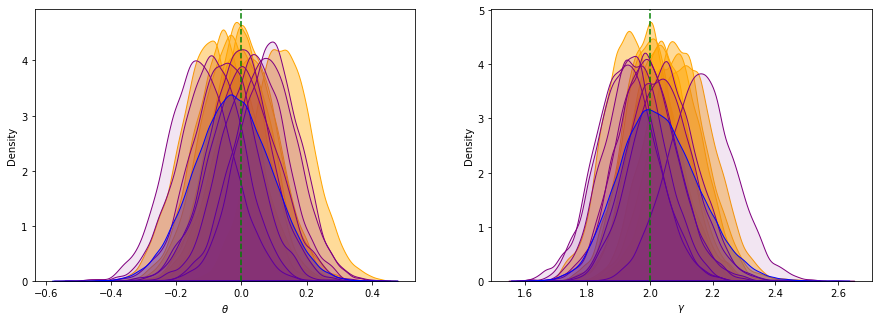

In [12]:
f,ax=plt.subplots(1,2,figsize=(15,5))
    
n_chains=15

for i in range(8):
    sns.kdeplot(Cauchy_X[i]["chains"][0],label="{} indep. chains given X".format(n_chains),ax=ax[0],color="orange",alpha=.4,fill=True,linewidth=1)
    sns.kdeplot(Cauchy_X[i]["chains"][1],label="{} indep. chains given X".format(n_chains),ax=ax[1],color="orange",alpha=.4,fill=True,linewidth=1)    

for i in range(8):
    sns.kdeplot(Cauchy_med_IQR[i]["chains"][0],label="{} indep. chains given median,MAD".format(n_chains),ax=ax[0],color="purple",alpha=.1,fill=True,linewidth=1)
    sns.kdeplot(Cauchy_med_IQR[i]["chains"][1],label="{} indep. chains given median,MAD".format(n_chains),ax=ax[1],color="purple",alpha=.1,fill=True,linewidth=1)
# if n_chains_ms>1:
#     sns.kdeplot(np.array([Cauchy_X[i]["chains"][0] for i in range(8)]).reshape(-1),label="Aggregation of {} chains given X".format(8),ax=ax[0],color = "red",fill=True,linewidth=0.1)
#     sns.kdeplot(np.array([Cauchy_X[i]["chains"][1] for i in range(8)]).reshape(-1),label="Aggregation of {} chains given X".format(8),ax=ax[1],color = "red",fill=True,linewidth=0.1)

if n_chains>1:
    sns.kdeplot(np.array([Cauchy_med_IQR[i]["chains"][0] for i in range(n_chains)]).reshape(-1),label="Aggregation of {} chains given median,MAD".format(8),ax=ax[0],color = "blue",fill=True,linewidth=1)
    sns.kdeplot(np.array([Cauchy_med_IQR[i]["chains"][1] for i in range(n_chains)]).reshape(-1),label="Aggregation of {} chains given median,MAD".format(8),ax=ax[1],color = "blue",fill=True,linewidth=1)
ax[0].axvline(0,linestyle="dashed",color="green",label="Med and MAD")
ax[1].axvline(2,linestyle="dashed",color="green")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
#ax[0].legend(by_label.values(), by_label.keys())
ax[0].set_xlabel(r"$\theta$")
ax[1].set_xlabel(r"$\gamma$")
plt.show()

(2, 15, 10001) (2, 15, 10001)
(15, 2) (15, 2)
biais : X = 1.0745449064491932, IQR = 1.0677531786637677
ratio X/IQR=  1.0063607656911169 ratio IQR/X=  0.9936794379232893
variance1 : X = 0.008150122646613932 IQR = 0.009992336320536846


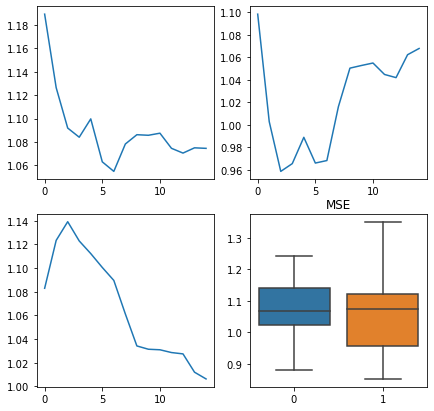

In [13]:
STD=[.2,.05,.1,.15,.05,.03]
N_L=[1001]

MSE_N=[]
n_chains=15
L_X=[Cauchy_X]
L_MAD=[Cauchy_med_IQR]
for i in range(len(N_L)):

    #print(len(Final_L[i][0][0]["X"][0]))
    # Chains_X= np.array([[Final_L[i][j][0]["chains"][0] for j in range(n_chains)],[Final_L[i][j][0]["chains"][1] for j in range(n_chains)]])
    # print(Chains_X[-1,-1,-1])
    # Chains_MAD= np.array([[Final_L[i][j][1]["chains"][0] for j in range(n_chains)],[Final_L[i][j][1]["chains"][1] for j in range(n_chains)]])
    #Chain_X = np.array([Final_L[i][j][0]["chains"][0] for j in range(n_chains)])
    Chains_X=np.array([[L_X[i][j]["chains"][0] for j in range(n_chains)],[L_X[i][j]["chains"][1] for j in range(n_chains)]]) 
    Chains_MAD=np.array([[L_MAD[i][j]["chains"][0] for j in range(n_chains)],[L_MAD[i][j]["chains"][1] for j in range(n_chains)]])
    print(Chains_X.shape,Chains_MAD.shape)
    
    mean_X=np.mean(Chains_X,axis=2).T
    mean_MAD=np.mean(Chains_MAD,axis=2).T
    var_X=np.var(Chains_X,axis=2).T
    var_MAD=np.var(Chains_MAD,axis=2).T
    print(mean_X.shape,mean_MAD.shape)
    med_MAD=np.array([np.repeat(0,n_chains),np.repeat(1,n_chains)]).T.reshape(-1,2)
    #med_MAD = np.array([medMAD(L_X[i][j]["X"][0]) for j in range(n_chains)])

    MSE_X = np.sum((mean_X-med_MAD)**2,axis=1)
    MSE_MAD = np.sum((mean_MAD-med_MAD)**2,axis=1)
    MSE_N.append([np.mean(MSE_X),np.mean(MSE_MAD)])
    
    print('biais : X = {}, IQR = {}'.format(np.mean(MSE_X),np.mean(MSE_MAD)))
    print('ratio X/IQR= ',np.mean(MSE_X)/np.mean(MSE_MAD),"ratio IQR/X= ",np.mean(MSE_MAD)/np.mean(MSE_X))
    print("variance1 : X = {} IQR = {}".format(np.mean(var_X),np.mean(var_MAD)))
    f,ax=plt.subplots(2,2,figsize=(7,7))
    ax[0,0].plot(np.cumsum(MSE_X)/np.arange(1,n_chains+1))
    ax[0,1].plot(np.cumsum(MSE_MAD)/np.arange(1,n_chains+1))
    ax[1,0].plot(np.cumsum(MSE_X)/np.cumsum(MSE_MAD))
    sns.boxplot(data=[MSE_X,MSE_MAD],ax=ax[1,1])
    ax[1,1].set_title("MSE")
    plt.show()

    B2_X= np.sum(np.abs(mean_X-med_MAD)**2,axis=1)**2
    B2_MAD=np.sum(np.abs(mean_MAD-med_MAD)**2,axis=1)**2
    
    #plt.plot(np.cumsum(MSE_X)/np.cumsum(MSE_MAD),label="N = {}".format(N_L[i]))
    Var_X=np.sum(np.var(mean_X,axis=0))
    Var_MAD=np.sum(np.var(mean_MAD,axis=0))

In [ ]:
len()

# Weibull 2 param

2.081386527894244 1.602625003032058


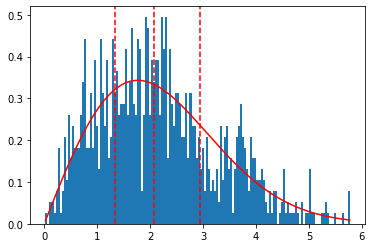

In [79]:
N=1001
T=500000

scale = 2.5 
shape = 2
loc = 0
X=scipy.stats.weibull_min(c=shape,loc=loc,scale=scale).rvs(N)
med_X,IQR_X=np.median(X),scipy.stats.iqr(X)
Q1_X,Q3_X=np.quantile(X,.25),np.quantile(X,.75)
# med,IQR=np.median(X),scipy.stats.iqr(X)
# print(med,IQR)
med,IQR=weibull_min(c=shape,scale=scale,loc=loc).ppf(.5),weibull_min(c=shape,scale=scale,loc=loc).ppf(.75)-weibull_min(c=shape,scale=scale,loc=loc).ppf(.25)
print(med,IQR)
Q3,Q1=weibull_min(c=shape,scale=scale,loc=loc).ppf(.75),weibull_min(c=shape,scale=scale,loc=loc).ppf(.25)
x=np.linspace(np.min(X),np.max(X),1000)

plt.hist(X[:1000000],bins=150,density=True)
plt.plot(x,weibull_min.pdf(x,scale=scale,c=shape,loc=loc),color="red")
plt.axvline(med,color="red",linestyle="--")
plt.axvline(Q1,color="red",linestyle="--")
plt.axvline(Q3,color="red",linestyle="--")

In [39]:

np.log(np.log(3)/np.log(2))/np.log(IQR_X/med_X),(np.log(np.log(3))-np.log(np.log(2)))/(np.log(IQR_X)-np.log(med_X))

(-1.5918812490665133, -1.591881249066514)

In [100]:
from MAD import *

In [121]:
IQRe=[]
IQRt=[]
MADe=[]
Xt=[]
# W2_theob=[]
X_L=[]
N=1001
T=40000
n_chains=5
for i in range(n_chains):
    loc,scale,shape=0,3,3
    X=scipy.stats.weibull_min(c=shape,loc=loc,scale=scale).rvs(N)

    Xt.append(Gibbs_med_MAD(T,N,np.median(X),scipy.stats.median_abs_deviation(X),1,"weibull2",[0,10,2,2,2,2],std_prop1=.002,std_prop2=.1,std_prop3=.1,perturb=False,init_X=X))
    med_X,IQR_X,MAD_X=np.median(X),scipy.stats.iqr(X),scipy.stats.median_abs_deviation(X)
    med_theo,IQR_theo=scipy.stats.weibull_min(c=shape,loc=loc,scale=scale).ppf(.5),scipy.stats.weibull_min(c=shape,loc=loc,scale=scale).ppf(.75)-scipy.stats.weibull_min(c=shape,loc=loc,scale=scale).ppf(.25)
    Q1_X,Q3_X=np.quantile(X,.25),np.quantile(X,.75)
    IQRt.append(Gibbs_med_IQR(T,N,med_theo,IQR_theo,1,"weibull2",[0,10,2,2,2,2],std_prop_quantile=1.9,std_prop1=.002,std_prop2=.1,std_prop3=.1))
    X_L.append(X)
    IQRe.append(Gibbs_med_IQR(T,N,med_X,IQR_X,1,"weibull2",[0,10,2,2,2,2],std_prop_quantile=1.9,std_prop1=.002,std_prop2=.1,std_prop3=.1))
    MADe.append(Gibbs_med_MAD(T,N,med_X,MAD_X,1,"weibull2",[0,10,2,2,2,2],std_prop1=.002,std_prop2=.1,std_prop3=.1))
    
    #W2b.append(Gibbs_med_MAD(T,N,med_X,IQR_X,1,"weibull2",[0,10,2,2,2,2],std_prop_quantile=1.9,std_prop1=.002,std_prop2=.1,std_prop3=.1))


100%|██████████| 40000/40000 [00:21<00:00, 1856.94it/s]


Acceptation rate of loc = 0.00%, of scale = 36.56% and of shape = 59.83%
[0, 1.2814649506379427, 1] [2.65499113 1.36465215] [2.15485171, 2.65499113, 3.51950386] [2.15485171] [2.15485171 2.65499113 3.51950386]


100%|██████████| 40000/40000 [03:41<00:00, 180.70it/s]


(1, 40001)
Acceptance rate of Q 0 = 40.35%
Acceptance rate of Q =  40.35%
[0, 1.2646244105309403, 1] [2.64046807 1.38587092] [2.12464836, 2.64046807, 3.51051928] [2.12464836] [2.12464836 2.64046807 3.51051928]


100%|██████████| 40000/40000 [03:42<00:00, 179.98it/s]


(1, 40001)
Acceptance rate of Q 0 = 40.98%
Acceptance rate of Q =  40.98%


100%|██████████| 40000/40000 [00:49<00:00, 804.95it/s]


Acceptation rate of loc = 0.00%, of scale = 38.20% and of shape = 57.94%


100%|██████████| 40000/40000 [00:21<00:00, 1894.11it/s]


Acceptation rate of loc = 0.00%, of scale = 35.40% and of shape = 61.89%
[0, 1.2582109115670665, 1] [2.65499113 1.36465214] [2.11051662, 2.65499113, 3.47516876] [2.11051662] [2.11051662 2.65499113 3.47516876]


100%|██████████| 40000/40000 [03:36<00:00, 185.01it/s]


(1, 40001)
Acceptance rate of Q 0 = 40.48%
Acceptance rate of Q =  40.48%
[0, 1.1865962053752936, 1] [2.66907058 1.33204921] [2.18846693, 2.66907058, 3.52051614] [2.18846693] [2.18846693 2.66907058 3.52051614]


100%|██████████| 40000/40000 [03:40<00:00, 181.03it/s]


(1, 40001)
Acceptance rate of Q 0 = 40.27%
Acceptance rate of Q =  40.27%


100%|██████████| 40000/40000 [00:47<00:00, 833.73it/s]


Acceptation rate of loc = 0.00%, of scale = 36.58% and of shape = 59.86%


100%|██████████| 40000/40000 [00:21<00:00, 1839.93it/s]


Acceptation rate of loc = 0.00%, of scale = 35.59% and of shape = 60.07%
[0, 1.2485989892591012, 1] [2.65499113 1.36465214] [2.15889338, 2.65499113, 3.52354552] [2.15889338] [2.15889338 2.65499113 3.52354552]


100%|██████████| 40000/40000 [03:50<00:00, 173.27it/s]


(1, 40001)
Acceptance rate of Q 0 = 40.38%
Acceptance rate of Q =  40.37%
[0, 1.262460155205201, 1] [2.6425217  1.35710376] [2.12407119, 2.6425217, 3.48117495] [2.12407119] [2.12407119 2.6425217  3.48117495]


100%|██████████| 40000/40000 [03:48<00:00, 174.77it/s]


(1, 40001)
Acceptance rate of Q 0 = 40.26%
Acceptance rate of Q =  40.25%


100%|██████████| 40000/40000 [00:50<00:00, 798.81it/s]


Acceptation rate of loc = 0.00%, of scale = 36.48% and of shape = 59.90%


100%|██████████| 40000/40000 [00:21<00:00, 1849.43it/s]


Acceptation rate of loc = 0.00%, of scale = 36.96% and of shape = 59.24%
[0, 1.3352583550203287, 1] [2.65499113 1.36465214] [2.15236619, 2.65499113, 3.51701833] [2.15236619] [2.15236619 2.65499113 3.51701833]


100%|██████████| 40000/40000 [03:39<00:00, 182.56it/s]


(1, 40001)
Acceptance rate of Q 0 = 40.87%
Acceptance rate of Q =  40.87%
[0, 1.3367066765176663, 1] [2.66231109 1.41471788] [2.16522677, 2.66231109, 3.57994465] [2.16522677] [2.16522677 2.66231109 3.57994465]


100%|██████████| 40000/40000 [03:37<00:00, 183.65it/s]


(1, 40001)
Acceptance rate of Q 0 = 41.10%
Acceptance rate of Q =  41.10%


100%|██████████| 40000/40000 [00:48<00:00, 831.37it/s]


Acceptation rate of loc = 0.00%, of scale = 39.51% and of shape = 57.04%


100%|██████████| 40000/40000 [00:21<00:00, 1894.68it/s]


Acceptation rate of loc = 0.00%, of scale = 35.69% and of shape = 60.68%
[0, 1.2849386137434462, 1] [2.65499113 1.36465215] [2.14010613, 2.65499113, 3.50475828] [2.14010613] [2.14010613 2.65499113 3.50475828]


100%|██████████| 40000/40000 [03:37<00:00, 183.80it/s]


(1, 40001)
Acceptance rate of Q 0 = 40.71%
Acceptance rate of Q =  40.71%
[0, 1.236082263545563, 1] [2.68834379 1.36484729] [2.20887, 2.68834379, 3.57371729] [2.20887] [2.20887    2.68834379 3.57371729]


100%|██████████| 40000/40000 [03:39<00:00, 181.98it/s]


(1, 40001)
Acceptance rate of Q 0 = 40.18%
Acceptance rate of Q =  40.18%


100%|██████████| 40000/40000 [00:48<00:00, 828.14it/s]


Acceptation rate of loc = 0.00%, of scale = 37.65% and of shape = 59.18%


In [98]:
print("Theoretical Median = {}, Theoretical IQR = {}".format(scale*(np.log(2)**(1/shape)),scale*(np.log(4)**(1/shape))-scale*(np.log(4/3)**(1/shape))))
print("Theoretical Q1 = {}, Theoretical Q3 = {}".format(scale*(np.log(4/3)**(1/shape)),scale*(np.log(4)**(1/shape))))

print("Theoretical Median = {}, Theoretical IQR = {}".format(scipy.stats.weibull_min(c=shape,scale=scale).ppf(1/2),scipy.stats.weibull_min(c=shape,scale=scale).ppf(3/4)-scipy.stats.weibull_min(c=shape,scale=scale).ppf(1/4)))

Theoretical Median = 2.6549911335015532, Theoretical IQR = 1.36465214493407
Theoretical Q1 = 1.9804270714487857, Theoretical Q3 = 3.3450792163828558
Theoretical Median = 2.6549911335015532, Theoretical IQR = 1.36465214493407


Means : Loc = 0.0 Scale = 2.942468395825943 Shape = 2.976565197006112 median = 2.65499113 iqr = 1.36465215
Means : Loc = 0.0 Scale = 2.9431217424013045 Shape = 2.955215567391668 median = 2.65499113 iqr = 1.36465214
Means : Loc = 0.0 Scale = 2.942301319178091 Shape = 2.9700196931689806 median = 2.65499113 iqr = 1.36465214


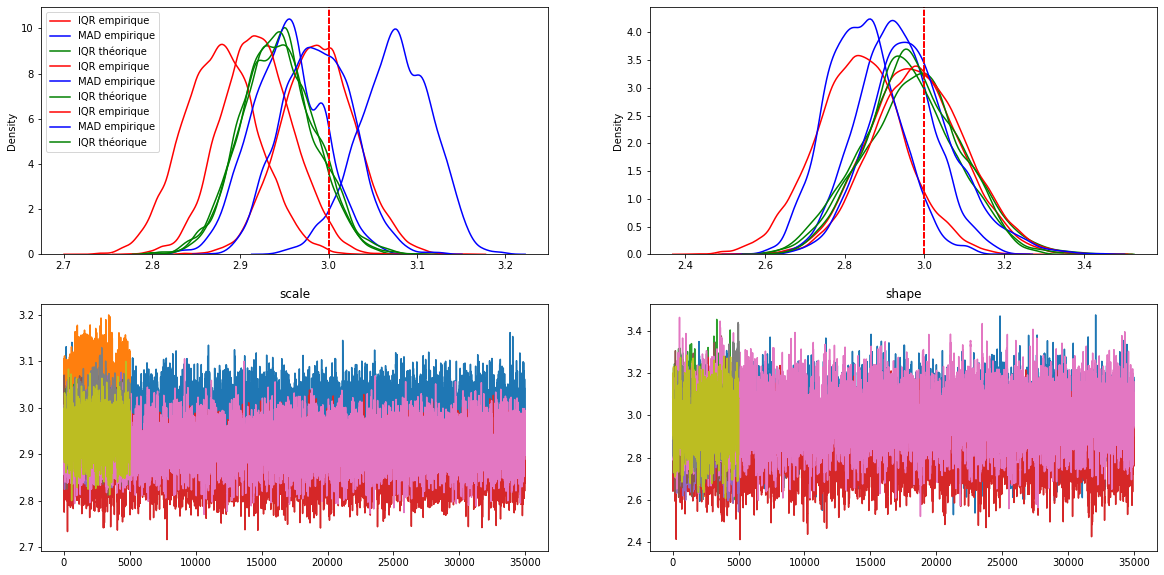

In [118]:
burnin=5000
n_chains=3
f,ax=plt.subplots(2,2,figsize=(20,10))
for i in range(n_chains):
    Gibbs=W2[i]
    sns.kdeplot(Gibbs["chains"][1][burnin:],ax=ax[0,0],color="red",label="IQR empirique")
    ax[0,0].axvline(scale,color="red",linestyle="--")
    ax[1,0].plot(Gibbs["chains"][1][burnin:])
    ax[1,0].set_title("scale")

    sns.kdeplot(Gibbs["chains"][2][burnin:],ax=ax[0,1],color="red")
    ax[0,1].axvline(shape,color="red",linestyle="--")
    ax[1,1].plot(Gibbs["chains"][2][burnin:])
    ax[1,1].set_title("shape")
    
    Gibbs=W2b[i]
    sns.kdeplot(Gibbs["chains"][1][burnin:],ax=ax[0,0],color="blue",label="MAD empirique")
    ax[0,0].axvline(scale,color="red",linestyle="--")
    ax[1,0].plot(Gibbs["chains"][1][burnin:])
    ax[1,0].set_title("scale")

    sns.kdeplot(Gibbs["chains"][2][burnin:],ax=ax[0,1],color="blue")
    ax[0,1].axvline(shape,color="red",linestyle="--")
    ax[1,1].plot(Gibbs["chains"][2][burnin:])
    ax[1,1].set_title("shape")
    
    Gibbs=W2_theo[i]
    sns.kdeplot(Gibbs["chains"][1][burnin:],ax=ax[0,0],color="green",label="IQR théorique")
    ax[0,0].axvline(scale,color="red",linestyle="--")
    ax[1,0].plot(Gibbs["chains"][1][burnin:])
    ax[1,0].set_title("scale")

    sns.kdeplot(Gibbs["chains"][2][burnin:],ax=ax[0,1],color="green")
    ax[0,1].axvline(shape,color="red",linestyle="--")
    ax[1,1].plot(Gibbs["chains"][2][burnin:])
    ax[1,1].set_title("shape")
    print("Means : Loc = {} Scale = {} Shape = {} median = {} iqr = {}".format(np.mean(Gibbs["chains"][0][burnin:]),np.mean(Gibbs["chains"][1][burnin:]),np.mean(Gibbs["chains"][2][burnin:]),np.median(Gibbs["X"][0]),scipy.stats.iqr(Gibbs["X"][0])))
ax[0,0].legend()

0.0 2.450214476583007 1.9925099380362736


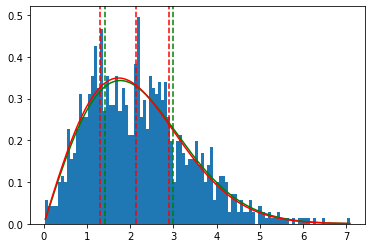

In [31]:
i=-1
dico=Weibull2

X=dico["X"][i]

plt.hist(X,bins=100,density=True)
x=np.linspace(np.min(X),np.max(X),1000)

plt.plot(x,scipy.stats.weibull_min(c=shape,loc=loc,scale=scale).pdf(x),color="green")

loc,scale,shape=np.mean(dico["chains"][:,1000:],axis=1)
print(loc,scale,shape)

plt.plot(x,scipy.stats.weibull_min(c=shape,loc=loc,scale=scale).pdf(x),color="red")

plt.axvline(np.median(X),color="red",linestyle="--")
plt.axvline(Q1_X,color="green",linestyle="--")
plt.axvline(Q3_X,color="green",linestyle="--")

plt.axvline(np.quantile(X,.25),color="red",linestyle="--")
plt.axvline(np.quantile(X,.75),color="red",linestyle="--")


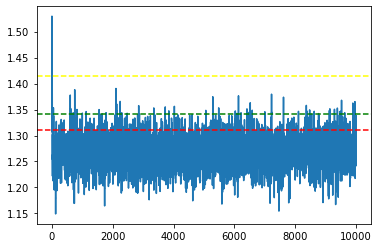

In [32]:
plt.plot(Weibull2["Q_sim"])
loc_sim,scale_sim,shape_sim=np.mean(Weibull2["chains"][:,1000:],axis=1)

Q3_sim,Q1_sim=weibull_min(c=shape_sim,scale=scale_sim,loc=loc_sim).ppf(.75),weibull_min(c=shape_sim,scale=scale_sim,loc=loc_sim).ppf(.25)
plt.axhline(Q1_sim,color="red",linestyle="--")
plt.axhline(Q1,color="green",linestyle="--")
plt.axhline(Q1_X,color="yellow",linestyle="--")

IQR sim =  1.7272866446460888 IQR =  1.602625003032058


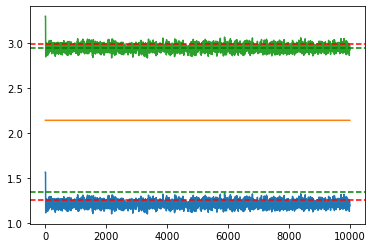

In [27]:
plt.plot(Weibull2["Q_tot"])
plt.axhline(Q1_sim,color="red",linestyle="--")
plt.axhline(Q3_sim,color="red",linestyle="--")
plt.axhline(Q1,color="green",linestyle="--")
plt.axhline(Q3,color="green",linestyle="--")
print("IQR sim = ",Q3_sim-Q1_sim,"IQR = ",Q3-Q1)


# Weibull 3 param

4.081386527894244 1.602625003032058


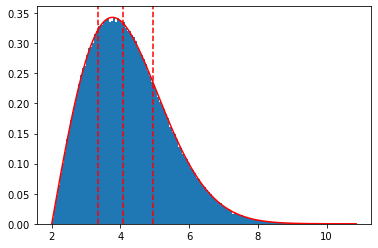

In [133]:
N=5001
T=500000

scale = 2.5 
shape = 2
loc = 2
X=scipy.stats.weibull_min(c=shape,loc=loc,scale=scale).rvs(N*100)

# med,IQR=np.median(X),scipy.stats.iqr(X)
# print(med,IQR)
med,IQR=weibull_min(c=shape,scale=scale,loc=loc).ppf(.5),weibull_min(c=shape,scale=scale,loc=loc).ppf(.75)-weibull_min(c=shape,scale=scale,loc=loc).ppf(.25)
print(med,IQR)
Q3,Q1=weibull_min(c=shape,scale=scale,loc=loc).ppf(.75),weibull_min(c=shape,scale=scale,loc=loc).ppf(.25)
x=np.linspace(np.min(X),np.max(X),1000)

plt.hist(X[:1000000],bins=150,density=True)
plt.plot(x,weibull_min.pdf(x,scale=scale,c=shape,loc=loc),color="red")
plt.axvline(med,color="red",linestyle="--")
plt.axvline(Q1,color="red",linestyle="--")
plt.axvline(Q3,color="red",linestyle="--")

3.0305858218205115

In [140]:

N=1001
T=200000
Weibull3=Gibbs_med_IQR(T,N,med,IQR,1,"weibull",[0,10,2,2,2,2],std_prop_quantile=1.5,std_prop1=.002,std_prop2=.1,std_prop3=.1)

[2.971643682239095, 1.5519416011066218, 1] [4.08138653 1.602625  ] [3.42851437, 4.08138653, 5.03113937] [3.42851437] [3.42851437 4.08138653 5.03113937]


100%|██████████| 200000/200000 [19:46<00:00, 168.60it/s]


(1, 200001)
Acceptance rate of Q 0 = 49.68%
Acceptance rate of Q =  49.68%
Acceptation rate of loc = 96.66%, of scale = 42.60% and of shape = 52.41%


Means : Loc = 1.5894780580029557 Scale = 2.8257925690636707 Shape = 2.332552191574236


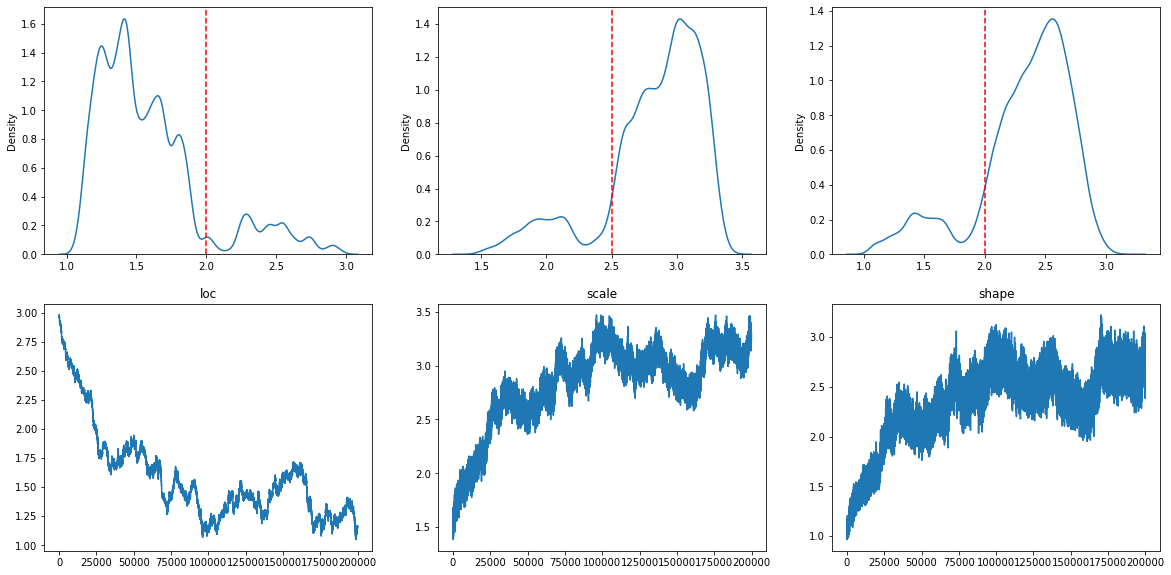

In [141]:
Gibbs=Weibull3

burnin=100

f,ax=plt.subplots(2,3,figsize=(20,10))
sns.kdeplot(Gibbs["chains"][0][burnin:],ax=ax[0,0])
ax[0,0].axvline(loc,color="red",linestyle="--")
ax[1,0].plot(Gibbs["chains"][0][burnin:])
ax[1,0].set_title("loc")

sns.kdeplot(Gibbs["chains"][1][burnin:],ax=ax[0,1])
ax[0,1].axvline(scale,color="red",linestyle="--")
ax[1,1].plot(Gibbs["chains"][1][burnin:])
ax[1,1].set_title("scale")

sns.kdeplot(Gibbs["chains"][2][burnin:],ax=ax[0,2])
ax[0,2].axvline(shape,color="red",linestyle="--")
ax[1,2].plot(Gibbs["chains"][2][burnin:])
ax[1,2].set_title("shape")
print("Means : Loc = {} Scale = {} Shape = {}".format(np.mean(Gibbs["chains"][0][burnin:]),np.mean(Gibbs["chains"][1][burnin:]),np.mean(Gibbs["chains"][2][burnin:])))

1.5834263751754434 2.831511498631923 2.338167119532135


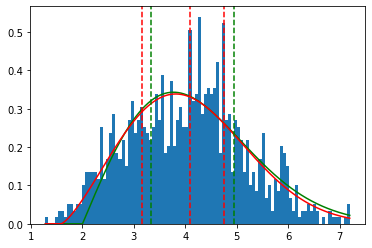

In [142]:
i=-1
dico=Weibull3

X=dico["X"][i]

plt.hist(X,bins=100,density=True)
x=np.linspace(np.min(X),np.max(X),1000)

plt.plot(x,scipy.stats.weibull_min(c=shape,loc=loc,scale=scale).pdf(x),color="green")

loc,scale,shape=np.mean(dico["chains"][:,1000:],axis=1)
print(loc,scale,shape)

plt.plot(x,scipy.stats.weibull_min(c=shape,loc=loc,scale=scale).pdf(x),color="red")

plt.axvline(np.median(X),color="red",linestyle="--")
plt.axvline(Q1,color="green",linestyle="--")
plt.axvline(Q3,color="green",linestyle="--")

plt.axvline(np.quantile(X,.25),color="red",linestyle="--")
plt.axvline(np.quantile(X,.75),color="red",linestyle="--")


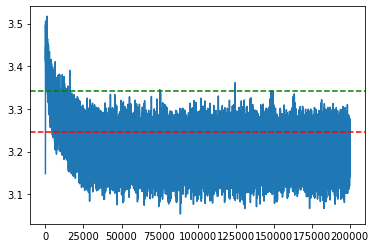

In [143]:
plt.plot(Weibull3["Q_sim"])
loc_sim,scale_sim,shape_sim=np.mean(Weibull3["chains"][:,1000:],axis=1)

Q3_sim,Q1_sim=weibull_min(c=shape_sim,scale=scale_sim,loc=loc_sim).ppf(.75),weibull_min(c=shape_sim,scale=scale_sim,loc=loc_sim).ppf(.25)
plt.axhline(Q1_sim,color="red",linestyle="--")
plt.axhline(Q1,color="green",linestyle="--")

IQR sim =  1.5941322103723854 IQR =  1.602625003032058


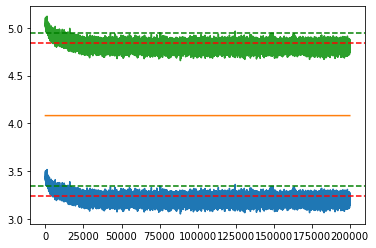

In [144]:
plt.plot(Weibull3["Q_tot"])
plt.axhline(Q1_sim,color="red",linestyle="--")
plt.axhline(Q3_sim,color="red",linestyle="--")
plt.axhline(Q1,color="green",linestyle="--")
plt.axhline(Q3,color="green",linestyle="--")
print("IQR sim = ",Q3_sim-Q1_sim,"IQR = ",Q3-Q1)

In [52]:
STD,MAD,IQR=[],[],[]
for i in tqdm(range(100000)):
    X=np.random.normal(0,1,30000)
    STD.append(np.std(X))
    MAD.append(scipy.stats.median_abs_deviation(X)/scipy.stats.norm.ppf(3/4))
    IQR.append(scipy.stats.iqr(X)/(2*scipy.stats.norm.ppf(3/4)))

100%|██████████| 100000/100000 [03:43<00:00, 446.84it/s]


In [49]:
scipy.stats.norm.ppf(3/4)

0.6744897501960817

In [51]:
a=scipy.stats.norm.ppf(3/4)**2
print(np.var(STD)/np.var(MAD),np.var(STD)/np.var(IQR),4*a/(np.math.pi*np.exp(a)))

0.36943086763118177 0.3695779906963343 0.3675229375956029


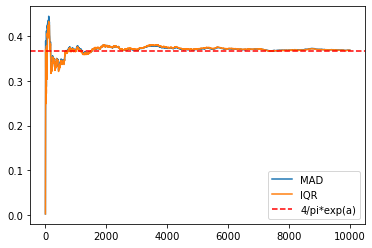

In [62]:
#cumMAD=np.array([np.var(STD[:i])/np.var(MAD[:i]) for i in tqdm(range(1,10001))])
#cumIQR=np.array([np.var(STD[:i])/np.var(IQR[:i]) for i in tqdm(range(1,10001))])
                 
plt.plot(cumMAD[:],label="MAD")
plt.plot(cumIQR[:],label="IQR")
plt.axhline(4*a/(np.math.pi*np.exp(a)),color="red",linestyle="--",label="4/pi*exp(a)")

plt.legend()

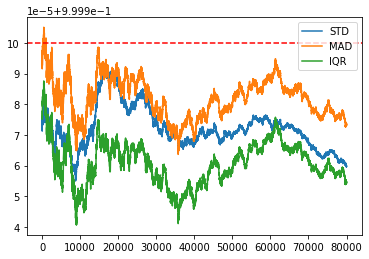

In [78]:
k=20000
plt.plot((np.cumsum(STD)/np.arange(1,100001))[k:],label="STD")
plt.plot((np.cumsum(MAD)/np.arange(1,100001))[k:],label="MAD")
plt.plot((np.cumsum(IQR)/np.arange(1,100001))[k:],label="IQR")
plt.axhline(1,color="red",linestyle="--")
plt.legend()

In [77]:
N=30000
n=N//4 
p3=(3*n+1)/(N+1)
p1=(n+1)/(N+1)
Var_IQR=(p3*(1-p3)/((n+2)*norm.pdf(norm.ppf(p3))**2))+((p1*(1-p1)/((n+2)*norm.pdf(norm.ppf(p1))**2)))
np.var(STD)/(Var_IQR)/axh(2*scipy.stats.norm.ppf(3/4))**2,np.var(STD)/np.var(IQR)

(0.018517063286117106, 0.3683623864747412)

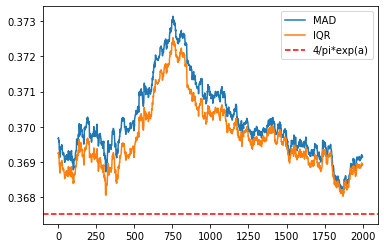

In [60]:
plt.plot(cumMAD[8000:],label="MAD")
plt.plot(cumIQR[8000:],label="IQR")
plt.axhline(4*a/(np.math.pi*np.exp(a)),color="red",linestyle="--",label="4/pi*exp(a)")

plt.legend()